# Evaluating Classifier Model Performance

## Precision, Recall, AUC and more

*It's 4am and you're on your seventh coffee.  You've trawled the forums to find the most sophisticated model you can.  You've set up your preprocessing pipeline and you've picked your hyperparameters.  Now, time to evaluate your model's performance.*

*You're shaking with excitement (or it could be the caffeine overdose).  This is it—your big debut onto the Kaggle world stage.  As your predictions are being submitted, your thoughts turn to what you're going to do with the prize money.  A Lamborghini or a Ferrari?  And in what colour?  The red goes best with cream upholstery, but at the same time...*

*The leader board pops up on your screen as if to announce something.*

*Your model performance has gotten worse.  You sit in silence for what seems like an age.*

*Eventually you sigh, close your laptop lid, and go to bed.*

If you've tried building a model before, you'll know that it's an iterative process.  Progress isn't linear—there can be long periods where it seems like you're getting no closer to your objective, or even going backwards—until that breakthrough occurs and you surge forward... and right into the next problem.

Monitoring model performance on a validation set is an excellent way to get feedback on whether what you're doing is working.  It's also a great tool for comparing two different models—ultimately, our aim is to build better, more accurate models that will help us make better decisions in real world applications.  When we're trying to communicate the value of a model to a stakeholder in a particular situation, they're going to want to know why they should care: what's in it for them?  How is it going to make their life easier?  We need to be able to compare what we've built to the systems that are already in place.

Evaluating model performance can tell us if our approach is working—this turns out to be helpful.  We can continue to explore and see how far we can push our existing conceptualisation of the problem we're working on.  It can also tell us if our approach isn't working—this turns out to be *even more* helpful because if our adjustments are making the model worse at what it's supposed to be doing, then it indicates that we may have misunderstood our data or the situation being modelled.  

So evaluation of model performance is useful—but how exactly do you do it?

## Exploring by way of an example

For the moment, we are going to concentrate on a particular class of model—classifiers.  These models are used to put unseen instances of data into a particular class—for example, we could set up a *binary classifier* (two classes) to distinguish whether a given image is of a dog or a cat.  More practically, a binary classifier could be used to decide whether an incoming email should classified as spam, whether a particular financial transaction is fraudulent, or whether a promotional email should be sent to a particular customer of an online store based on their shopping history.

The techniques and metrics used to assess the performance of a classifier will be different from those used for a *regressor*, which is a type of model that attempts to predict a value from a continuous range.  Both types of model are common, but for now, let's limit our analysis to classifiers.

To illustrate some of the important concepts, we'll set up a simple classifier that predicts whether an image of a particular image is a seven or not.  Let's use the famous NMIST dataset to train and test our model.

Below, we use Scikit-Learn to download our data and to build our classifier.  First, import Matplotlib for plotting:

In [1]:
# Import modules for maths and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')

Then, use scikit-learn's built-in helper function to download the data.  The data comes as a dictionary—we can use the "data" key to access instances of training and test data (the images of the digits) and the "target" key to access the labels (what the digits have been hand-labelled as).

In [2]:
# Fetch and load data
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

The full dataset contains a whopping 70,000 images—let's take a subset of 10% of the data to make it easier to quickly train and test our model.

In [3]:
# Extract features and labels
data, labels = mnist["data"], mnist["target"].astype(np.uint8)

# Split into train and test datasets
train_data, test_data, train_labels, test_labels = data[:6000], data[60000:61000], labels[:6000], labels[60000:61000]

Now, let's briefly inspect the first few digits in our training data.  Each digit is actually represented by 784 values from 0 to 255, which represent how dark each pixel in a 28 by 28 grid should be.  We can easily reshape the data into a grid and plot the data using matplotlib's imshow() function:

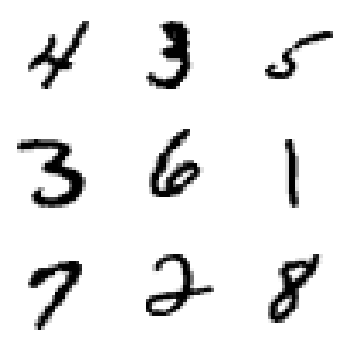

In [4]:
# Plot a selection of digits from the dataset
example_digits = train_data[9:18]

# Set up plotting area
fig = plt.figure(figsize=(6,6))

# Set up subplots for each digit - we'll plot each one side by side to illustrate the variation
ax1, ax2, ax3 = fig.add_subplot(331), fig.add_subplot(332), fig.add_subplot(333)
ax4, ax5, ax6 = fig.add_subplot(334), fig.add_subplot(335), fig.add_subplot(336)
ax7, ax8, ax9 = fig.add_subplot(337), fig.add_subplot(338), fig.add_subplot(339)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

# Plot the digits
for i in range(9):
    
    ax = axs[i]
    ax.imshow(example_digits[i].reshape(28, 28), cmap="binary")
    ax.set_xticks([], []) 
    ax.set_yticks([], []) 

# Save figure to .png image
plt.savefig('example_digits.png')

Now, let's create a new set of labels—we are only interested at the moment in whether an image of a seven or not.  Once that's done, we can train a model to hopefully pick up the characteristics that make a digit "seven-y":

In [5]:
# Create new labels based on whether a digit is a 7 or not
train_labels_7 = (train_labels == 7) 
test_labels_7 = (test_labels == 7)

# Import, instantiate and fit model
from sklearn.linear_model import SGDClassifier

sgd_clf_7 = SGDClassifier(random_state=0) 
sgd_clf_7.fit(train_data, train_labels_7) 

# Make predictions using our model for the nine digits shown above
sgd_clf_7.predict(example_digits)

array([False, False, False, False, False, False,  True, False, False])

For our model, we've used an *SGD* (or *Stochastic Gradient Descent*) classifier.  And for our array of nine example digits, it looks like our model is doing the right kind of thing—it has correctly identified the one seven from the eight other not-sevens.  Let's make predictions on our data using 3-fold cross-validation:

In [6]:
from sklearn.model_selection import cross_val_predict

# Use 3-fold cross-validation to make "clean" predictions on our training data
train_data_predictions = cross_val_predict(sgd_clf_7, train_data, train_labels_7, cv=3)

train_data_predictions

array([False, False, False, ..., False, False, False])

Ok—now we have a set of predictions for each instance in our training set.  It may sound strange that we are making *predictions* on our *training data,* but we avoid making predictions on data the model has already been trained on by using [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/)—follow the link to learn more.

## True and false positives/negatives

At this point, let's take a step back and think about the different situations we might find ourselves in for a given model prediction.

- The model may predict a 7, and the image is actually a 7 (true positive);
- The model may predict a 7, and the image is actually not a 7 (false positive);
- The model may predict a not-7, and the image is actually a 7 (false negative); and
- The model may predict a not-7, and the image is actually not a 7 (true negative).

We use the terms true/false positive (TP/FP) and true/false negative (TN/FN) to describe each of the four possible outcomes listed above.  The true/false part refers to whether the model was correct or not.  The positive/negative part refers to whether the instance being classified actually was or was not the instance we wanted to identify. 

A good model will have a high level of true positive and true negatives, because these results indicate where the model has got the right answer.  A good model will also have a low level of false positives and false negatives, which indicate where the model has made mistakes.  

These four numbers can tell us a lot about how the model is doing and what we can do to help.  Often, it's helpful to represent them as a *confusion matrix.*

## Confusion matrix

We can use scikit-learn to easily extract the confusion matrix: 

In [7]:
from sklearn.metrics import confusion_matrix

# Show confusion matrix for our SGD classifier's predictions
confusion_matrix(train_labels_7, train_data_predictions)

array([[5232,  117],
       [  72,  579]], dtype=int64)

The columns of this matrix represent what our model has predicted—not-7 on the left and 7 on the right.  The rows represent what each instance that the model predicted actually was—not-7 on the top and 7 on the bottom.  The number in each position tells us the number of each situation that was observed when comparing our predictions to the actual results.

So in summary, out of 6,000 test cases, we observed (considering a "positive" result as being a 7 and a "negative" one being some other digit):

- 579 predicted 7s that were actually 7s (TPs);
- 72 predicted not-7s that were actually 7s (FNs);
- 117 predicted 7s that were actually not-7s (FPs);
- 5,232 predicted not-7s that were actually not-7s (TNs).

You may have noticed that ideally our confusion matrix would be *diagonal*—that is, only consisting of true positives and true negatives.  The fact that our classifier seems to be struggling more with false positives than false negatives gives us useful information when deciding how we should proceed to improve our model further.

## Precision and recall

We can use the information encoded in the confusion matrix to calculate some further useful quantities.  *Precision* is defined as the number of true positives as a proportion of all (true and false) positives.  Effectively, this number represents *how many of the model's positive predictions actually turned out to be right.*

For our model above, the precision is 579 / (579 + 117) = 83.2%.  This means that out of all the digits we *predicted* to be 7s in our dataset, only 83.2% were *actually* 7s.

However, precision must also be considered in tandem with *recall.*  Recall is defined as the number of true positives as a proportion of both true positives and false negatives.  Remember that both true positives and false negatives relate to cases where the digit being considered *actually was* a 7.  So in summary, recall represents *how good the model is at correctly identifying positive instances.*  

For our model above, the recall is 579 / (579 + 72) = 88.9%.  In other words, our model *only caught 88.9% of the digits that were actually 7s.*

We can also save ourselves from having to calculate these quantities manually by getting them directly from our model:

In [8]:
from sklearn.metrics import precision_score, recall_score

# Calculate and print precision and recall as percentages
print("Precision: " + str(round(precision_score(train_labels_7, train_data_predictions)*100,1))+"%")
print("Recall: " + str(round(recall_score(train_labels_7, train_data_predictions)*100,1))+"%")

Precision: 83.2%
Recall: 88.9%


We can set a *desired level of precision or recall* by playing about with the *threshold* of the model.  In the background, our SGD classifier has come up with a *decision score* for each digit in the data which corresponds to how "seven-y" a digit is.  Digits that appear to be very seven-y will have a higher score.  Digits that the model doesn't think look like sevens at all will have a low score.  Ambiguous cases (perhaps poorly drawn sevens that look a bit like ones) will be somewhere in the middle.  All digits with a decision score above the model's threshold will be predicted to be 7s, and all those with scores below the threshold will be predicted as not-7s.  Hence, if we want to increase our recall (and increase the number of 7s that we successfully identify) we can lower the threshold.  By doing this, we are effectively saying to the model, "Lower your standards for identifying sevens a bit".  We will then catch more of the ambiguous sevens, *the proportion of the actual 7s in the data that we correctly identify will increase, and our recall will go up.*  In addition to increasing the number of TPs, we will also lower the number of FNs—7s that were previously mistakenly identified as not-7s will start to be correctly identified.  

You may have noticed, however, that in reducing the threshold, we are likely to now misclassify more not-7s.  That one which was drawn to look a bit like a seven may now be predicted incorrectly to be a 7.  Hence, we will start to get an increasing number of false positive results and *our precision will trend downwards as our recall increases.*  This is the *precision–recall trade-off*.  You can't have your cake and eat it too.  The best models will be able to strike a good balance between the two so that both precision and recall are at an acceptable level.

What level of precision and recall constitutes "acceptable"?  That depends on how the model is going to be applied.  If the consequences of failing to identify a positive instance are severe, for example if you were a doctor aiming to detect the presence a life-threatening disease, you may be willing to suffer a few more false positives (and send some people who don't have the disease for some unnecessary further tests) to reduce false negatives (a circumstance under which someone would not receive the life-saving treatment they need).  Similarly, if you had a situation in which it was necessary to be very confident in your positive predictions, for example if you were choosing a property to purchase or picking a location for a new oil well, you may be happy to pass up a few opportunities (ie have your model predict a few more false negatives) if it means that you are less likely to invest time and money as a result of a false positive. 

## Visualising the precision–recall trade-off

We can observe how precision and recall vary with the decision threshold (for the calculation of our metrics above, scikit-learn has used a threshold of zero):

In [18]:
# Use cross_val_predict to get our model's decision scores for each digit it has predicted
train_data_decision_scores = cross_val_predict(sgd_clf_7, train_data, train_labels_7, cv=3,
                                                method="decision_function")

from sklearn.metrics import precision_recall_curve

# Obtain possible combinations of precisions, recalls, and thresholds
precisions, recalls, thresholds = precision_recall_curve(train_labels_7, train_data_decision_scores)

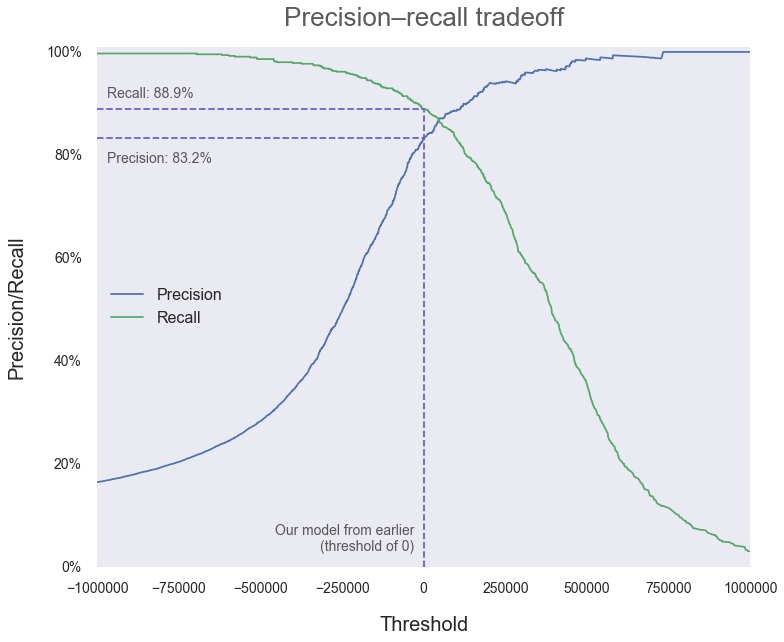

In [19]:
# Set up plotting area
fig, ax = plt.subplots(figsize=(11,9))

# Plot decision and recall curves
ax.plot(thresholds, precisions[:-1], label="Precision")
ax.plot(thresholds, recalls[:-1], label="Recall")

# Add legend to distinguish lines
ax.legend(loc="center left", fontsize=16)

# Add x- and y-axis labels
ax.set_xlabel("Threshold", labelpad=20, fontsize=20)
ax.set_ylabel("Precision/Recall", labelpad=20, fontsize=20)

# Set appropriate x- and y-axis limits
ax.axis([-1000000,1000000,0,1.01])

# Add title
ax.text(x = 0, y = 1.05, s = "Precision–recall tradeoff", fontsize = 26, alpha = .75, ha="center")

# Remove gridlines
ax.grid(False)

# Set font sizes and padding for tick labels
ax.tick_params(axis="x", labelsize=14, pad=15)
ax.tick_params(axis="y", labelsize=14, pad=15)

# Format y-axis to show percentages rather than decimals
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Plot precision and recall when threshold is equal to zero
ax.plot([0, 0], [0.0, 0.889], "slateblue", linestyle="dashed")
ax.plot([-1000000, 0], [0.889, 0.889], "slateblue", linestyle="dashed")
ax.plot([-1000000, 0], [0.832, 0.832], "slateblue", linestyle="dashed")

# Add labels for these values
ax.text(x = -970000, y = 0.785, s = "Precision: 83.2%", fontsize = 14, alpha = .75, ha="left")
ax.text(x = -970000, y = 0.91, s = "Recall: 88.9%", fontsize = 14, alpha = .75, ha="left")
ax.text(x = -30000, y = 0.03, s = "Our model from earlier\n(threshold of 0)", fontsize = 14, alpha = .75, ha="right")

# Set tight layout
plt.tight_layout()

# Save figure to .png image
plt.savefig('precision_recall_curve.png')

As you can see, precision and recall are two sides of the same coin.  Generally (that is, in the absence of a specific reason to seek out more of one at the possible expense of the other) we will want to tune our model so that our decision threshold is set in the region where both precision and recall are high. 

We can also plot precision and recall directly against each other as the decision threshold is varied:

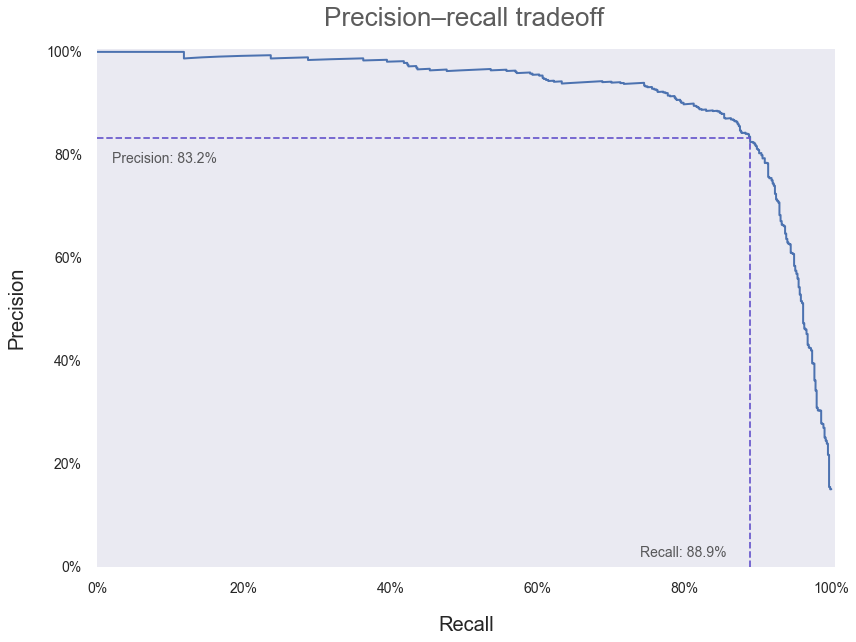

In [20]:
# Set up plotting area
fig, ax = plt.subplots(figsize=(12,9))

# Plot pairs of precision and recall for differing thresholds
ax.plot(recalls, precisions, linewidth=2)

# Add x- and y-axis labels
ax.set_xlabel("Recall", labelpad=20, fontsize=20)
ax.set_ylabel("Precision", labelpad=20, fontsize=20)

# Set x- and y-axis limits
ax.axis([0, 1.005, 0, 1.005])

# Remove gridlines
ax.grid(False)

# Set font sizes and padding for tick labels
ax.tick_params(axis="x", labelsize=14, pad=15)
ax.tick_params(axis="y", labelsize=14, pad=15)

# Plot on the precision and recall for our SGD model with threshold of zeros
plt.plot([0.889, 0.889], [0., 0.832], "slateblue", linestyle="dashed")
plt.plot([0.0, 0.889], [0.832, 0.832], "slateblue", linestyle="dashed")

# Add title
ax.text(x = 0.5, y = 1.05, s = "Precision–recall tradeoff", fontsize = 26, alpha = .75, ha="center")

# Format axes to show percentages rather than decimals
x_vals = ax.get_xticks()
y_vals = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])

# Add labels for the values of precision and recall for our particular SGD model
ax.text(x = 0.02, y = 0.785, s = "Precision: 83.2%", fontsize = 14, alpha = .75, ha="left")
ax.text(x = 0.74, y = 0.02, s = "Recall: 88.9%", fontsize = 14, alpha = .75, ha="left")

# Set tight layout
plt.tight_layout()

# Save figure to .png image
plt.savefig('precision_recall_curve_2.png')

We've also included the point along the curve where our current model (with a decision threshold of zero) lies.  In an ideal world, we would have a model that could achieve both 100% precision and 100% recall—that is, we would want a precision–recall curve that passes through the top right-hand corner of our plot above.  Hence, any adjustments that we make to our model that push our curve outwards and towards the upper right can be regarded as improvements. 

## F1 score

For applications where precision and recall are of similar importance, it is often convenient to combine them into a single quantity called the *F1 score.*  The F1 score is defined as being the harmonic mean of the precision and recall scores.  It's a bit harder to intuitively interpret the F1 score than it is for precision and recall individually, but it may be desirable to summarise the two quantities into one, easy-to-compare metric.  

To obtain a high F1 score, a model needs to have both high precision and recall.  This is because the F1 score is dragged down quite significantly when taking the harmonic mean if one of precision or recall is low. 

In [12]:
from sklearn.metrics import f1_score

# Obtain and print F1 score as a percentage
print("F1 score: " + str(round(f1_score(train_labels_7, train_data_predictions)*100,1))+"%")

F1 score: 86.0%


## ROC (receiver operating characteristic) and AUC (area under curve)

Another common way of assessing (and visualising) model performance is by using the ROC curve.  Historically, it has its origins in signal detection theory and was first used in the context of detecting enemy aircraft in World War II, where the ability of a radar receiver operator to detect and make decisions based on incoming signals was referred to as Receiver Operating Characteristic.  Although the precise context in which it is generally used today has changed, the name has stuck.

The ROC curve plots how the *True Positive rate* and the *False Positive rate* change as the model threshold is varied.  The true positive rate is simply the percentage of positive instances that were correctly identified (ie the number of 7s we correctly predicted).  The false positive rate is, correspondingly, the number of negative instances that were incorrectly identified as being positive (ie the number of not-7s that were incorrectly predicted to be 7s).  You may have noticed that the definition for the true positive rate is equivalent to that of recall.  And you'd be correct—these are simply different names for the same metric.

To get a bit of an intuition about what a good and a bad ROC curve would look like (as it's often a bit tricky to think about what these more abstract quantities actually mean), let's consider the extreme cases—the best and worst possible classifiers we could possibly have.

The *worst possible classifier* will essentially make a random, 50/50 guess as to whether a given digit is a 7 or not a 7—it has made no attempt to learn what distinguishes the two classes.  The decision scores for each instance will essentially be randomly distributed.  Say we initially set the decision threshold at a very high value so that all instances are classified as negative.  We will have identified no positive instances—true or false—so both the true positive and false positive rates are zero.  As we decrease the decision threshold, we will gradually start classifying equal numbers of positive and negative instances as being positive, so that the true and false positive rates increase at the same pace.  This continues until our threshold is at some very low value where we have the reverse of the situation we started with—correctly classifying all positive instances (so true positive rate is equal to one) but also incorrectly classifying all negative instances (false positive rate also one).  Hence, *the ROC curve for a random, 50/50 classifier is a diagonal line from (0,0) to (1,1).*

(You may think it's possible to have an even worse classifier than this—perhaps a classifier that gets every digit wrong by predicting the opposite every time.  But in that case, then the classifier would essentially be a perfect classifier—to be *so wrong,* the model would have needed to learn the classification perfectly and then just switch around the outputs before making a prediction!)

The *best possible classifier* will be able to correctly predict every given instance as positive or negative with 100% accuracy.  The decision scores for all positive instances will be some high value, to represent the fact that the model is supremely confident in its predictions, and equally so for every digit it has been given.  All negative instances will have some low decision score, since the model is, again, supremely and equally confident that all these instances are negative.  If we start the decision threshold at a very high value so that all instances are classified as negative, we have the same situation as described for the 50/50 classifier—both true and false positive rates are zero because we have not predicted any positive instances.  In the same way, when the decision threshold is very low, we will predict all instances to be positive and so will have a value of one for both true and false positive rates.  Hence, the ROC curve will start at (0,0) and end at (1,1), as for the 50/50 classifier.  *However,* when the decision threshold is set at any level between the high and low decision scores that identify positive and negative instances, the classifier will operate perfectly with a 100% true positive rate and a 0% false positive rate.  Amazing!  The consequences of the above is that the ROC curve for our perfect classifier is *the curve that joins up (0,0), (0,1) and (1,1)—a curve that hugs the upper left-hand corner of the plot.*

Most real-world classifiers will be somewhere between these two extremes.  Ideally, we will want our classifier's ROC curve to be closer to looking like a perfect classifier than one that guesses randomly—so *a ROC curve that lies closer to the upper left-hand corner of the plot (closer to the behaviour of a perfect classifier) represents a superior model.*

Armed with this new knowledge, let's plot some ROC curves.

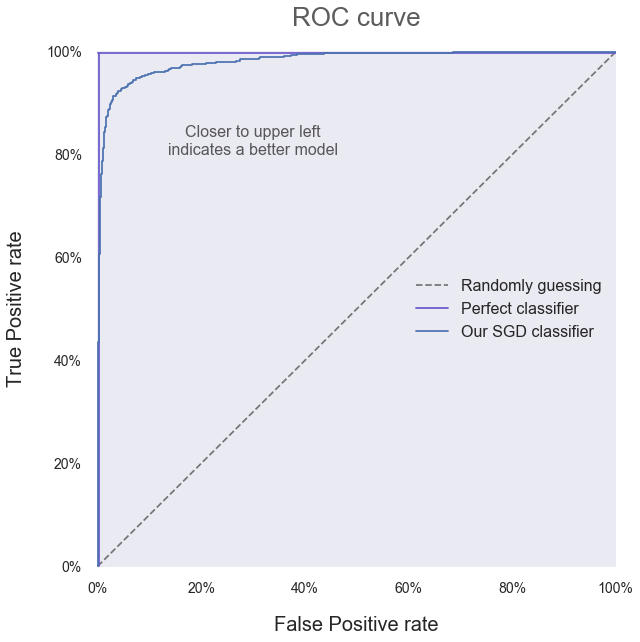

In [16]:
from sklearn.metrics import roc_curve

# Set up plotting area
fig, ax = plt.subplots(figsize=(9,9))

# Obtain possible combinations of true/false positive rates and thresholds
fpr, tpr, thresholds = roc_curve(train_labels_7, train_data_decision_scores)

# Remove gridlines
ax.grid(False)

# Set font sizes and padding for tick labels
ax.tick_params(axis="x", labelsize=14, pad=15)
ax.tick_params(axis="y", labelsize=14, pad=15)

# Plot random guess, 50/50 classifier
ax.plot([0,1], [0,1], "k--", alpha=0.5, label="Randomly guessing") 

# Plot perfect, omniscient classifier
ax.plot([0.002,0.002], [0,0.998], "slateblue", label="Perfect classifier")
ax.plot([0.001,1], [0.998,0.998], "slateblue")

# Plot our SGD classifier with threshold of zero
ax.plot(fpr, tpr, label="Our SGD classifier")

# Set x- and y-axis limits
ax.axis([-0.001,1.001,-0.001,1.001])

# Add legend to identify each of the three models
ax.legend(loc="center right", fontsize=16)

# Set x- and y-axis labels
ax.set_xlabel("False Positive rate", labelpad=20, fontsize=20)
ax.set_ylabel("True Positive rate", labelpad=20, fontsize=20)

# Format axes to show percentages rather than decimals
x_vals = ax.get_xticks()
y_vals = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])

# Add title
ax.text(x = 0.5, y = 1.05, s = "ROC curve", fontsize = 26, alpha = .75, ha="center")

# Add annotation
ax.text(x = 0.3, y = 0.8, s = "Closer to upper left\nindicates a better model", fontsize = 16, alpha = .75, ha="center")

# Set tight layout
plt.tight_layout()

# Save figure to .png image
plt.savefig('roc_curve_3.png')

It's clear that our SGD classifier is doing better than one that guesses randomly!  All that work was worth it after all.  Instead of relying on the vague statement that "closer to the upper left corner is better", we can quantify model performance by calculating the Area Under a model's ROC Curve—referred to as the *AUC.*

If you remember your formulae for calculating the area of a triangle, you should be able to see that the AUC for the random classifier is 0.5.  You should also be able to see that the AUC for the perfect classifier is 1.  Hence, a higher AUC is better and we will want to aim for an AUC as close to 1 as possible.  Our SGD classifier's AUC can be obtained as follows:

In [14]:
from sklearn.metrics import roc_auc_score

# Obtain and print AUC
print("Area Under Curve (AUC): " + str(round(roc_auc_score(train_labels_7, train_data_predictions),3)))

Area Under Curve (AUC): 0.934


In isolation, it's hard to tell exactly what our AUC of 0.934 means.  As with the metrics was saw earlier based on precision and recall, these are standard *comparative* tools.  We should use them purposefully to develop and tune our current model, and to compare our model to other algorithms to seek out the best possible performance at our particular task. 

## Conclusion

We covered a lot of information today, so congratulations if you made it all the way through!  When first taking on a problem, it's easy to become overwhelmed by the sheer range of algorithms, methods and parameters that could be used as part of an approach to solving it.  Model performance metrics can act as the compass that guides us through this wilderness—as long as we break a problem down, decide on an initial approach (we can change later if needed), and use sensible tools like those explained above to evaluate whether we are making progress,  we will be moving towards where we need to go.  And as heart-breaking as it is to not see hours of research and tinkering with a model reflected in an improvement in a particular performance metric, it's always better to know whether we are moving forwards or backwards.  

So get stuck in—and don't get too invested in a particular method if the numbers show that it's not working out.  Review and compare models and approaches dispassionately.  If you can manage that, you'll be sitting in that Ferrari with the cream upholstery in no time at all.

## Credits and more info

__Andrew Hetherington__ is an actuary-in-training and data enthusiast based in London, UK. 

- Check out my [website](https://www.andrewhetherington.com/).  

- Connect with me on [LinkedIn](https://www.linkedin.com/in/andrewmhetherington/).  

- Follow me on [Medium](https://medium.com/@andrew.m.hetherington/). 

- See what I’m tinkering with on [GitHub](https://github.com/andrewhetherington/python-projects).  

Code chunks in this notebook have been adapted from [A. Géron's 2019 book](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=pd_lpo_14_t_0/257-3076774-3184456?_encoding=UTF8&pd_rd_i=1492032646&pd_rd_r=dfb4d6ef-830b-45b4-a51e-655f75eb07c5&pd_rd_w=2JphL&pd_rd_wg=NXcYK&pf_rd_p=7b8e3b03-1439-4489-abd4-4a138cf4eca6&pf_rd_r=WR7PA4BFNEHM2DCHCMYC&psc=1&refRID=WR7PA4BFNEHM2DCHCMYC), *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow,* 2nd Edition, by Aurélien Géron (O'Reilly).  Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.